# Trading Signal Features

---

### Import Libraries and Dependencies

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

### Read in Stock Price Data directly from Yahoo as Pandas DataFrame

In [3]:
# Set up End and Start times for data grab
years = 10
# end = datetime.now() --> To use if end date is today
end = datetime(2021,1,5)
start = datetime(end.year - years, end.month, end.day) # Number of years prior to end date

# Identify stock data to grab by ticker
ticker = 'AAPL'

In [4]:
# Read in stock data
aapl_df = DataReader(ticker, 'yahoo', start, end)
aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-18,12.312857,11.642857,11.768571,12.166071,1.880998e+09,10.495069
2011-01-19,12.450000,12.031429,12.441071,12.101429,1.135613e+09,10.439302
2011-01-20,12.082143,11.790000,12.015357,11.881429,7.647892e+08,10.249522
2011-01-21,11.960000,11.665357,11.920357,11.668571,7.544012e+08,10.065897
2011-01-24,12.051786,11.668571,11.673929,12.051786,5.746832e+08,10.396482


In [5]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2011-01-18 to 2021-01-15
Data columns (total 6 columns):
High         2517 non-null float64
Low          2517 non-null float64
Open         2517 non-null float64
Close        2517 non-null float64
Volume       2517 non-null float64
Adj Close    2517 non-null float64
dtypes: float64(6)
memory usage: 137.6 KB


### Drop NAs and Calculate Daily Returns 

In [6]:
# Drop NAs and calculate daily percent return
aapl_df['daily_return'] = aapl_df['Close'].dropna().pct_change()
aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close,daily_return
Date,,,,,,,
2011-01-18,12.312857,11.642857,11.768571,12.166071,1.880998e+09,10.495069,NaN
2011-01-19,12.450000,12.031429,12.441071,12.101429,1.135613e+09,10.439302,-0.005313
2011-01-20,12.082143,11.790000,12.015357,11.881429,7.647892e+08,10.249522,-0.018180
2011-01-21,11.960000,11.665357,11.920357,11.668571,7.544012e+08,10.065897,-0.017915
2011-01-24,12.051786,11.668571,11.673929,12.051786,5.746832e+08,10.396482,0.032842


In [7]:
aapl_df.describe()

,High,Low,Open,Close,Volume,Adj Close,daily_return
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.000000,2516.000000
mean,37.065106,36.301131,36.682707,36.696523,2.543860e+08,35.007241,0.001095
std,25.441529,24.732792,25.093598,25.100307,2.004288e+08,25.679157,0.017975
min,11.346429,11.089286,11.310000,11.261429,4.544800e+07,9.714678,-0.128647
25%,20.045713,19.672144,19.822144,19.804285,1.141152e+08,17.451225,-0.007289
50%,28.632500,28.092501,28.407499,28.387501,1.830554e+08,26.336056,0.000758
75%,44.705002,43.767502,44.105000,44.222500,3.327816e+08,42.933674,0.010332
max,138.789993,134.339996,138.050003,136.690002,1.880998e+09,136.690002,0.119808


### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [8]:
# Set short and long windows
short_window = 5 # Was 1
long_window = 50 # Was 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
aapl_df['fast_close'] = aapl_df['Close'].ewm(halflife=short_window).mean()
aapl_df['slow_close'] = aapl_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
aapl_df['crossover_long'] = np.where(aapl_df['fast_close'] > aapl_df['slow_close'], 1.0, 0.0)
aapl_df['crossover_short'] = np.where(aapl_df['fast_close'] < aapl_df['slow_close'], -1.0, 0.0)
aapl_df['crossover_signal'] = aapl_df['crossover_long'] + aapl_df['crossover_short']

aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,,
2011-01-18,12.312857,11.642857,11.768571,12.166071,1.880998e+09,10.495069,NaN,12.166071,12.166071,0.0,0.0,0.0
2011-01-19,12.450000,12.031429,12.441071,12.101429,1.135613e+09,10.439302,-0.005313,12.131513,12.133526,0.0,-1.0,-1.0
2011-01-20,12.082143,11.790000,12.015357,11.881429,7.647892e+08,10.249522,-0.018180,12.036366,12.048326,0.0,-1.0,-1.0
2011-01-21,11.960000,11.665357,11.920357,11.668571,7.544012e+08,10.065897,-0.017915,11.924512,11.951404,0.0,-1.0,-1.0
2011-01-24,12.051786,11.668571,11.673929,12.051786,5.746832e+08,10.396482,0.032842,11.957463,11.972041,0.0,-1.0,-1.0


### Plot Exponential Moving Average of Closing Prices

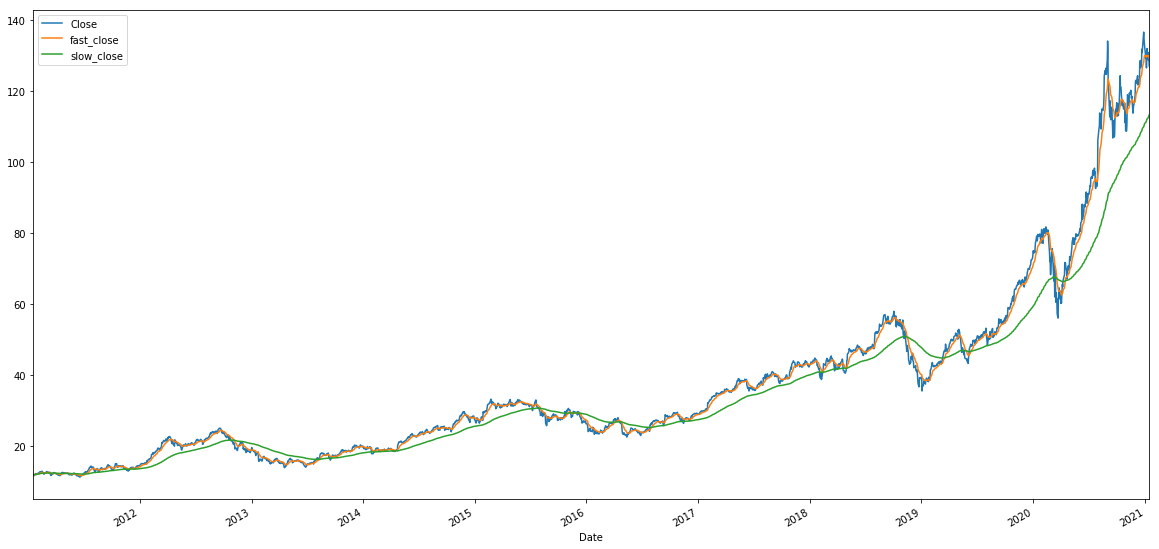

In [9]:
# Plot the EMA of AAPL closing prices
aapl_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [10]:
# Set short and long volatility windows
short_vol_window = 5 # Was 1
long_vol_window = 50 # Was 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
aapl_df['fast_vol'] = aapl_df['daily_return'].ewm(halflife=short_vol_window).std() # Only change from before is change mean() to std()and daily return versus closing price
aapl_df['slow_vol'] = aapl_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
aapl_df['vol_trend_long'] = np.where(aapl_df['fast_vol'] < aapl_df['slow_vol'], 1.0, 0.0)
aapl_df['vol_trend_short'] = np.where(aapl_df['fast_vol'] > aapl_df['slow_vol'], -1.0, 0.0) 
aapl_df['vol_trend_signal'] = aapl_df['vol_trend_long'] + aapl_df['vol_trend_short']

aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,,
2011-01-18,12.312857,11.642857,11.768571,12.166071,1.880998e+09,10.495069,NaN,12.166071,12.166071,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2011-01-19,12.450000,12.031429,12.441071,12.101429,1.135613e+09,10.439302,-0.005313,12.131513,12.133526,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2011-01-20,12.082143,11.790000,12.015357,11.881429,7.647892e+08,10.249522,-0.018180,12.036366,12.048326,0.0,-1.0,-1.0,0.009098,0.009098,1.0,0.0,1.0
2011-01-21,11.960000,11.665357,11.920357,11.668571,7.544012e+08,10.065897,-0.017915,11.924512,11.951404,0.0,-1.0,-1.0,0.007084,0.007327,1.0,0.0,1.0
2011-01-24,12.051786,11.668571,11.673929,12.051786,5.746832e+08,10.396482,0.032842,11.957463,11.972041,0.0,-1.0,-1.0,0.025789,0.024257,0.0,-1.0,-1.0


### Plot Exponential Moving Average of Daily Return Volatility

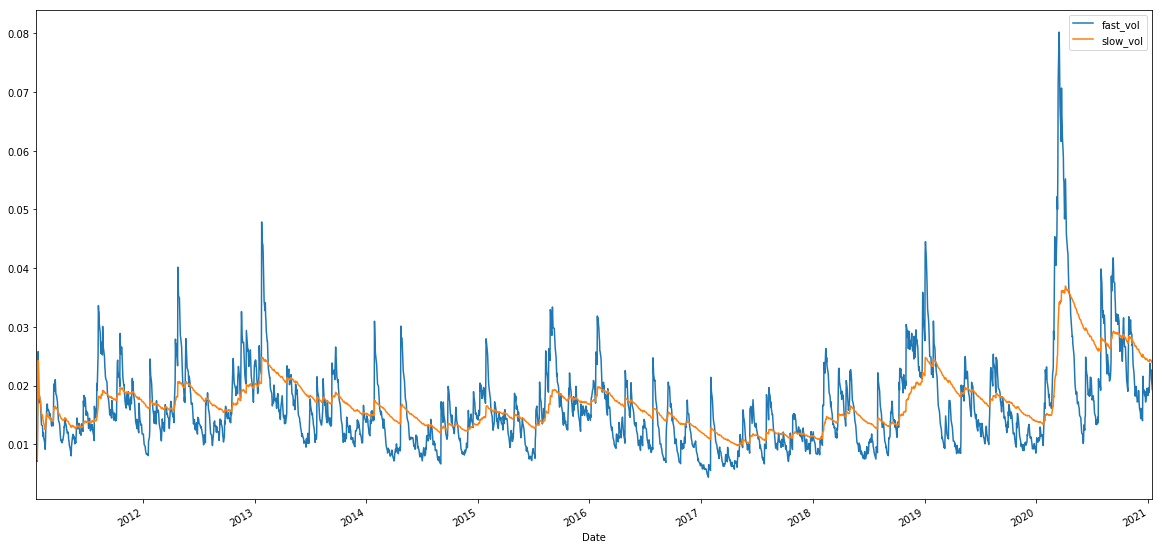

In [11]:
# Plot the EMA of AAPL daily return volatility
aapl_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

### Construct Bollinger Band (Trading Signal, Feature Three)

In [12]:
# Set bollinger band window
bollinger_window = 50 # Was 20 in classroom exercise

# Calculate rolling mean and standard deviation
aapl_df['bollinger_mid_band'] = aapl_df['Close'].rolling(window=bollinger_window).mean()
aapl_df['bollinger_std'] = aapl_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band (= 1 standard deviation)
aapl_df['bollinger_upper_band']  = aapl_df['bollinger_mid_band'] + (aapl_df['bollinger_std'] * 1)
aapl_df['bollinger_lower_band']  = aapl_df['bollinger_mid_band'] - (aapl_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
aapl_df['bollinger_long'] = np.where(aapl_df['Close'] < aapl_df['bollinger_lower_band'], 1.0, 0.0)
aapl_df['bollinger_short'] = np.where(aapl_df['Close'] > aapl_df['bollinger_upper_band'], -1.0, 0.0)
aapl_df['bollinger_signal'] = aapl_df['bollinger_long'] + aapl_df['bollinger_short']

aapl_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,129.410004,-0.024719,129.989153,111.214663,1.0,...,1.0,0.0,1.0,121.2828,4.683888,125.966688,116.598912,0.0,-1.0,-1.0
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,131.009995,0.012364,130.121301,111.487191,1.0,...,1.0,0.0,1.0,121.5880,4.519370,126.107370,117.068629,0.0,-1.0,-1.0
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,126.599998,-0.033662,129.665470,111.695254,1.0,...,1.0,0.0,1.0,121.8192,4.405512,126.224712,117.413688,0.0,-1.0,-1.0
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,130.919998,0.034123,129.827868,111.959926,1.0,...,1.0,0.0,1.0,122.1366,4.314964,126.451564,117.821636,0.0,-1.0,-1.0
2021-01-08,132.630005,130.229996,132.429993,132.050003,104965400.0,132.050003,0.008631,130.115522,112.236512,1.0,...,1.0,0.0,1.0,122.4456,4.016225,126.461824,118.429375,0.0,-1.0,-1.0
2021-01-11,130.169998,128.500000,129.190002,128.979996,100620900.0,128.979996,-0.023249,129.968529,112.467025,1.0,...,1.0,0.0,1.0,122.8012,3.743099,126.544299,119.058101,0.0,-1.0,-1.0
2021-01-12,129.690002,126.860001,128.500000,128.800003,91951100.0,128.800003,-0.001396,129.817264,112.691886,1.0,...,1.0,0.0,1.0,123.0708,3.332849,126.403649,119.737951,0.0,-1.0,-1.0
2021-01-13,131.449997,128.490005,128.759995,130.889999,88636800.0,130.889999,0.016227,129.956129,112.942425,1.0,...,1.0,0.0,1.0,123.5114,2.701434,126.212834,120.809966,0.0,-1.0,-1.0
2021-01-14,131.000000,128.759995,130.800003,128.910004,90221800.0,128.910004,-0.015127,129.820709,113.162255,1.0,...,1.0,0.0,1.0,123.9142,2.657597,126.571797,121.256603,0.0,-1.0,-1.0


### Plot Bollinger Bands

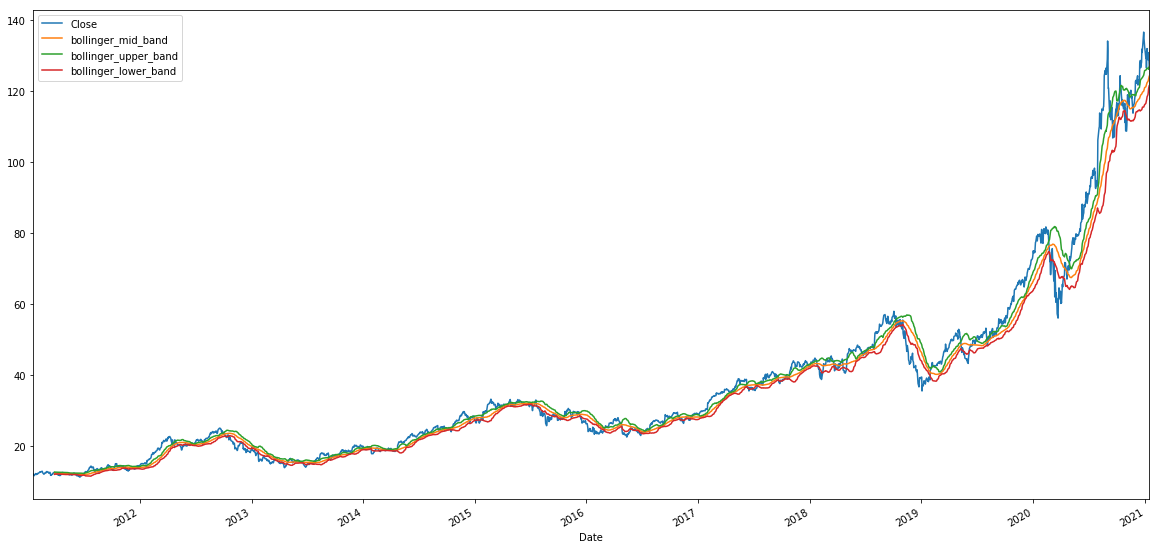

In [13]:
# Plot the Bollinger Bands for AAPL closing prices
aapl_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [14]:
aapl_df.to_csv(r'trading_signals.csv')